In [195]:
from TransformerModel import *
import torch
from torch import nn, Tensor
from torch.utils.data import dataset
import spacy
import numpy as np

In [196]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [197]:
bptt = 2048

In [198]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english') # Will try spacy
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

batch size, seq_len:  20 102499
batch size, seq_len:  10 21441
batch size, seq_len:  10 24185


In [199]:
train_data = data_process(train_iter)
train_data = train_data.to(device)

val_data = data_process(val_iter)
val_data = val_data.to(device)

test_data = data_process(test_iter)
test_data = test_data.to(device)

In [235]:
# help(train_data)
type(train_data)

torch.Tensor

In [237]:
def token_to_text(data):
    words = [vocab.get_itos()[token] for token in data]
    return ' '.join(words)

token_to_text(test_data[0:100])

"= robert <unk> = robert <unk> is an english film , television and theatre actor . he had a guest @-@ starring role on the television series the bill in 2000 . this was followed by a starring role in the play herons written by simon stephens , which was performed in 2001 at the royal court theatre . he had a guest role in the television series judge john <unk> in 2002 . in 2004 <unk> landed a role as craig in the episode teddy ' s story of the television series the long firm he starred alongside actors"

In [201]:
ntokens = len(vocab)  # size of vocabulary
emsize = 50  # embedding dimension (default 200)
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

In [202]:
model_file_name = './data/model_epoch_50.pth'

In [203]:
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
model.load_state_dict(torch.load(model_file_name))

c:\Users\ilya\anaconda3\envs\p39n\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [204]:
evaluate(model, val_data)

7.813818388808602

In [205]:
test_iter_list = list(test_iter)

In [206]:
data, targets = get_batch(test_data, 0)
print(data)
print(data.shape)
print(targets)
print(targets.shape)

tensor([  9, 632,   0,  ...,  41,   4,   1], device='cuda:0')
torch.Size([2048])
tensor([ 632,    0,    9,  ...,    4,    1, 2889], device='cuda:0')
torch.Size([2048])


In [207]:
token_to_text(data)

"= robert <unk> = robert <unk> is an english film , television and theatre actor . he had a guest @-@ starring role on the television series the bill in 2000 . this was followed by a starring role in the play herons written by simon stephens , which was performed in 2001 at the royal court theatre . he had a guest role in the television series judge john <unk> in 2002 . in 2004 <unk> landed a role as craig in the episode teddy ' s story of the television series the long firm he starred alongside actors mark strong and derek jacobi . he was cast in the 2005 theatre productions of the philip ridley play mercury fur , which was performed at the drum theatre in plymouth and the <unk> <unk> factory in london . he was directed by john <unk> and starred alongside ben <unk> , shane <unk> , harry kent , fraser <unk> , sophie stanton and dominic hall . in 2006 , <unk> starred alongside <unk> in the play <unk> written by mark <unk> . he appeared on a 2006 episode of the television series , doctor

In [208]:
outputs = model(data).cpu().detach().numpy()
outputs.shape

(2048, 28782)

In [209]:
outputs_tokens = np.argmax(outputs, axis=1)
token_to_text(outputs_tokens)

'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

# Semantic Geometry

In [215]:
my_embedding = model.embedding

In [238]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt = GPT2LMHeadModel.from_pretrained('gpt2')

In [179]:
[i for i in dir(model_gpt) if 'embed' in i]

['_get_resized_embeddings',
 '_resize_token_embeddings',
 'get_input_embeddings',
 'get_output_embeddings',
 'get_position_embeddings',
 'resize_position_embeddings',
 'resize_token_embeddings',
 'set_input_embeddings',
 'set_output_embeddings']

In [188]:
model_gpt.get_output_embeddings()

Linear(in_features=768, out_features=50257, bias=False)

In [181]:
model_gpt.get_output_embeddings

<bound method GPT2LMHeadModel.get_output_embeddings of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)>

In [240]:
word_token = data_process(['good day, how are you?']).to(device)
print(word_token)
token_to_text(word_token)

tensor([423, 132,   2, 416,  34, 178, 857], device='cuda:0')


'good day , how are you ?'

In [217]:
word_token = data_process(['queen king man woman']).to(device)
print(word_token)
token_to_text(word_token)

tensor([1099,  287,  240,  868], device='cuda:0')


'queen king man woman'

In [218]:
vocab_indices = torch.arange(len(vocab)).to(device)
vocab_embedding = my_embedding(vocab_indices)
print(vocab_embedding.shape)

torch.Size([28782, 50])


In [310]:
from sklearn.decomposition._pca import PCA

vocab_embedding_cpu = vocab_embedding.cpu().detach().numpy()
vocab_pca = PCA(n_components=10).fit(vocab_embedding_cpu)
vocab_latent = vocab_pca.transform(vocab_embedding_cpu)
vocab_latent.shape

(28782, 10)

In [319]:
w = 'man'

word_token = data_process([w]).to(device)
word_vector = my_embedding(word_token)[0].cpu().detach().numpy().reshape(1, 50)
word_vector_latent = vocab_pca.transform(word_vector)
word_vectors_latent.append(word_vector_latent)

In [362]:
# words = ['man', 'woman', 'king', 'queen']
words = vocab.get_itos()[100:1000:100]
word_vectors_latent = []

for w in words:
    word_token = data_process([w]).to(device)
    word_vector = my_embedding(word_token)[0].cpu().detach().numpy().reshape(1, 50)
    word_vector_latent = vocab_pca.transform(word_vector).reshape(10)
    word_vectors_latent.append(word_vector_latent)

(-2.7667978286743162, 0.5137749791145325)

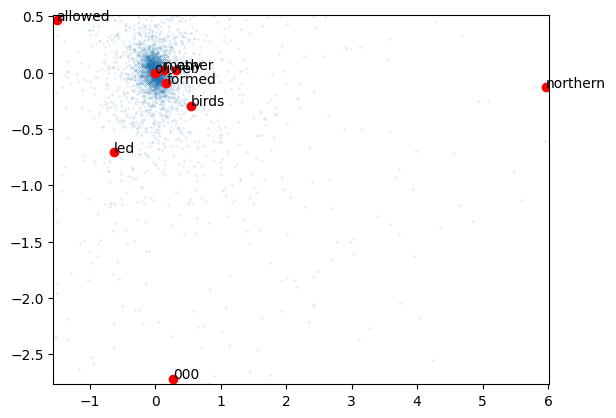

In [366]:
import matplotlib.pyplot as plt
plt.scatter(vocab_latent[:,0], vocab_latent[:,1], s=0.01)
for w, v in zip(words, word_vectors_latent):
    plt.plot(v[0], v[1], 'ro')
    plt.annotate(w, (v[0], v[1]))

xmin = min([v[0] for v in word_vectors_latent])
xmax = max([v[0] for v in word_vectors_latent])
ymin = min([v[1] for v in word_vectors_latent])
ymax = max([v[1] for v in word_vectors_latent])
eps = 0.05

plt.xlim(xmin-eps, xmax+eps)
plt.ylim(ymin-eps, ymax+eps)

In [219]:
def get_distances(vector, vocab_embedding=vocab_embedding):
    expanded_vector = vector.unsqueeze(0).expand_as(vocab_embedding)
    euclidean_distances = torch.sqrt(torch.sum((expanded_vector - vocab_embedding) ** 2, dim=1))
    return euclidean_distances.tolist()

def top_n_closest(distances):
    distances_tensor = torch.tensor(distances)
    smallest_distances, indices = torch.topk(distances_tensor, 10, largest=False)
    return smallest_distances.tolist(), indices.tolist()

def print_closest(vector, n=10, vocab_embedding=vocab_embedding):
    distances = get_distances(vector)
    smallest_distances, smallest_indices = top_n_closest(distances)
    words = [vocab.get_itos()[token] for token in smallest_indices]
    for i in range(n):
        print(f"{words[i]}: {smallest_distances[i]:.3f}")

In [220]:
word_token = data_process(['man']).to(device)
word_vector = model.embedding(word_token)[0]
print_closest(word_vector)

man: 0.000
peoples: 2.740
1972: 2.897
pity: 3.012
ranked: 3.062
18th: 3.141
little: 3.200
chamber: 3.217
indian: 3.247
lover: 3.261


In [221]:
king_token = data_process(['king']).to(device)
king_vector = my_embedding(king_token)[0]
man_token = data_process(['man']).to(device)
man_vector = my_embedding(man_token)[0]
woman_token = data_process(['woman']).to(device)
woman_vector = my_embedding(woman_token)[0]


print_closest(king_vector - man_vector + woman_vector)

14: 2.380
t: 2.566
interest: 2.581
funds: 2.615
good: 2.636
scotland: 2.648
rival: 2.651
literary: 2.666
1867: 2.728
chick: 2.741
